# BÁO CÁO BÀI TẬP LỚN HỌC MÁY
**Quora Insincere Question Classification**

**Mã lớp**: INT3405 20

**Họ tên**: Phan Quang Hùng

**MSSV**: 18020582


---

# 1. Tìm hiểu bài toán

## 1.1. Đặt vấn đề
**Quora** là một nền tảng hỏi đáp được tạo ra với mục đích để mọi người có thể học hỏi và chia sẻ kiến thức. Mọi người có thể đặt câu hỏi trên trang web này và kết nối với những người có thể có những câu trả lời chất lượng và đóng góp những thông tin chi tiết, độc đáo.

Tuy vậy, cũng vì Quora là một nơi dành cho tất cả mọi người mà không thể tránh khỏi một thực trạng đáng buồn: các **câu hỏi mang tính độc hại** (toxic question), hay nói cách khác, được đặt ra một cách **thiếu chân thành** (insincere). Chúng được đặt ra dựa trên những định kiến, tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích. Điều này đi ngược lại với tôn chỉ của Quora **"Be Nice, Be Respectful"** (dịch thô: hãy là một người tốt và biết tôn trọng người khác).

Từ đó mà cuộc thi **Quora Insincere Questions Classification** - Phân loại những câu hỏi Quora thiếu chân thành, được ra đời.

Nhiệm vụ được đặt ra là sử dụng tập dữ liệu mà Quora cung cấp để phân loại đâu là những câu hỏi mang hàm ý không chân thành.

## 1.2. Dữ liệu đầu vào và đầu ra
* **Input**: Tiêu đề câu hỏi. Định dạng văn bản (text).

* **Output**: Số 1/0 tương ứng với không chân thành/chân thành.

## 1.4. Đánh giá
Cuộc thi sử dụng F1 Score để đánh giá. F1 Score được sử dụng có thể là vì sự mất cân bằng của dữ liệu (xem thêm ở mục 2.3. Khảo sát và phân tích), nên sẽ có ý nghĩa hơn là sử dụng accuracy đơn thuần.


F1 score là trung bình điều hoà (Harmonic Mean) của Precision và Recall. 

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png "F1 Score")

## 1.3. Hướng giải quyết

Sử dụng **GloVE** để nhúng (embedding) ngôn ngữ thành các vector, sau đó dùng Mạng nơ-ron hồi quy (RNN - Recurrent Neural Network) như **LSTM** để xử lý.

# 2. Phân tích dữ liệu

## 2.1. Import thư viện

Trong số các thư viện được sử dụng, cần kể đến:
* `nltk`: Natural Language Toolkit, một bộ thư viện và chương trình dành cho xử lý ngôn ngữ tự nhiên thống kê và biểu tượng tiếng Anh.
* `pandas`: Thao tác với các dữ liệu dạng bảng (.csv).
* `torch`: PyTorch, một framework được phát triển chủ yếu bởi phòng thí nghiệm Nghiên cứu AI của Facebook.

In [2]:
import os
import re
import nltk
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torch
import torchtext
from torchtext import data
from torch import nn
# from torch.nn import functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
tqdm().pandas()

0it [00:00, ?it/s]

## 2.2. Nhập dữ liệu đầu vào

In [6]:
DATA_PATH = '../input/quora-insincere-questions-classification/'

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df  = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

## 2.3. Khảo sát và phân tích

### a. Trường dữ liệu

In [3]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Dữ liệu đầu vào cho thấy 3 cột thông tin:
* `qid`: ID của câu hỏi
* `question_text`: tiêu đề câu hỏi, dữ liệu ta cần phân loại
* `target`: kết quả cho thấy câu hỏi có thiếu chân thành không (1 - thiếu chân thành, 0 - chân thành)

In [148]:
print("Number of data points in training data:", train_df.shape[0])
print("Number of data points in test data:", test_df.shape[0])

Number of data points in training data: 1306122
Number of data points in test data: 375806


### b. Phân bố dữ liệu

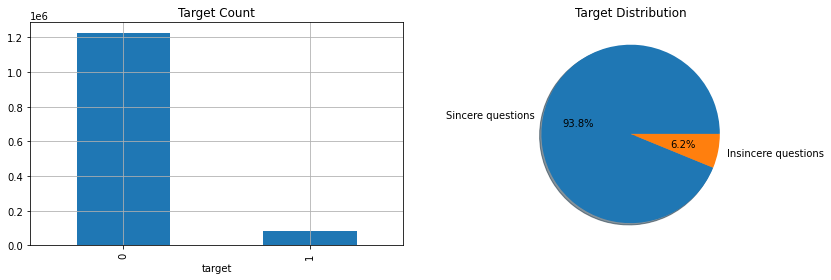

In [149]:
# Bar chart
plt.subplot(1, 2, 1)
train_df.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title('Target Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [train_df[train_df['target']==0].shape[0], train_df[train_df['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Target Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

**Vấn đề**: Có thể thấy số lượng câu hỏi thiếu chân thành (target = 1) **thấp hơn đáng kể** so với các câu hỏi chân thành.

**Giải pháp**: Đó là lý do tại sao các bài dự thi được đánh giá trên **F1 Score** giữa mục tiêu dự đoán và mục tiêu quan sát. 
Vì vậy, tập dữ liệu không cân bằng sẽ không ảnh hưởng đến điểm số. 





### c. Phân tích từ

Tiếp theo ta sẽ trích xuất một số đặc trưng dữ liệu cơ bản:
* `count`: Số lượng từ 
* `mean`: Trung bình số lượng từ 
* `std`: Sample standard deviation
* `min`: Số lượng từ nhỏ nhất
* `max`: Số lượng từ lớn nhất
* `50%/80%/99.99%`: Số lượng từ theo thống kê mà 50%/80%/99.99% câu hỏi có số lượng thấp hơn

Lấy được thông tin này trực tiếp từ lệnh `describe` của pandas.

In [38]:
#train_df['num_words'] = train_df['question_text'].apply(lambda x: len(str(x).split()))
#print("Maximum length of a sincere question:", max(train_df[train_df['target']==0]['num_words']))
#print("Maximum length of a insincere question:", max(train_df[train_df['target']==]['num_words']))

Maximum length of a sincere question: 134
Maximum length of a insincere question: 64


Phân tích dựa trên tổng số câu hỏi ở bộ dữ liệu train:

In [150]:
train_df['word_count']= train_df.question_text.progress_apply(lambda x: len(x.split()))
#data_neg = train_df[train_df['target']==0]
#data_pos = train_df[train_df['target']==1]

#statistic = pd.merge(
#    data_neg.describe(percentiles=[.8, .9999])
#    data_pos[['word_count']].describe(percentiles=[.8, .9999]), 
#    left_index=True, right_index=True, suffixes=('_sincere', '_insincere')
#)
train_df.describe(percentiles=[.8, .9999]).apply(lambda s: s.apply('{0:.2f}'.format))

  0%|          | 0/1306122 [00:00<?, ?it/s]

,target,word_count
count,1306122.00,1306122.00
mean,0.06,12.80
std,0.24,7.05
min,0.00,1.00
50%,0.00,11.00
80%,0.00,17.00
99.99%,1.00,53.00
max,1.00,134.00


Tách bảng thành 2 cột câu hỏi chân thành và không chân thành để phân tích.

  0%|          | 0/1306122 [00:00<?, ?it/s]

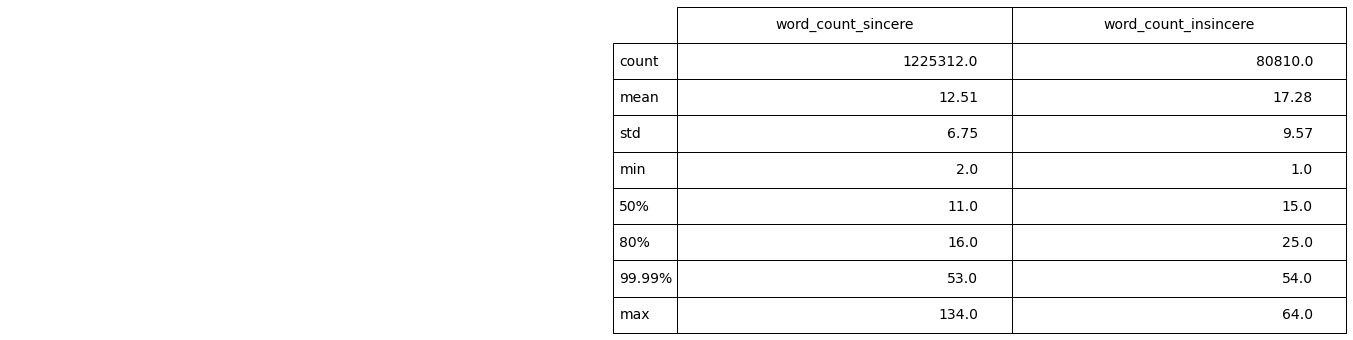

In [151]:
train_df['word_count']= train_df.question_text.progress_apply(lambda x: len(x.split()))
data_neg = train_df[train_df['target']==0]
data_pos = train_df[train_df['target']==1]

statistic = pd.merge(
    data_neg[['word_count']].describe(percentiles=[.8, .9999]), 
    data_pos[['word_count']].describe(percentiles=[.8, .9999]), 
    left_index=True, right_index=True, suffixes=('_sincere', '_insincere')
)
#statistic.describe(percentiles=[.8, .9999]).apply(lambda s: s.apply('{0:.2f}'.format))

colLabels = statistic.columns
cellText = statistic.round(2).values
rowLabels = statistic.index

fig, axes = plt.subplots()
#axes = fig.add_axes([0,0,1,1])
#axes.bar(['sincere question', 'insincere question'], train_df.target.value_counts())
for p in axes.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height / len(train_df)
    x, y = p.get_xy() 
    axes.annotate(f'{percent:.2%}', (x + width/2, y + height + 0.01*len(train_df)), ha='center')
    
axes.axis('off')
mpl_table = axes.table(cellText = cellText, colLabels=colLabels, rowLabels = rowLabels, bbox=[2, 0, 2, 1.5], )
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(14)

Bộ dữ liệu:
* **Độ dài trung bình**: 12.8
* **Số lượng từ ít nhất**: 1
* **Số lượng từ cao nhất**: 134
* **50% số câu có ít hơn**: 11
* **80% số câu có ít hơn**: 17
* **99.99% số câu có ít hơn**: 53

Đặc điểm đáng chú ý của câu thiếu chân thành:
* **Độ dài trung bình**: 17.28
* **50% số câu có ít hơn**: 15
* **80% số câu có ít hơn**: 25

Đặc điểm đáng chú ý của câu hỏi chân thành:
* **Độ dài trung bình**: 12.51
* **50% số câu có ít hơn**: 11
* **80% số câu có ít hơn**: 16

**Nhận xét**:

Vì số lượng câu chân thành chiếm đa số, nên không ngạc nhiên khi số liệu của nó khá tương đồng số liệu của tổng bộ dữ liệu.

Giữa hai class dữ liệu, có thể thấy rằng **câu không chân thành có xu hướng dài hơn câu hỏi chân thành**.

### d. Phân tích chữ và ký tự đặc biệt

Tiếp theo ta sẽ trích xuất các loại chữ và ký tự đặc biệt:
* `capital_letters`: Chữ viết hoa 
* `special_char`: Ký tự đặc biệt 
* `unique_words`: Từ độc nhất, chỉ xuất hiện duy nhất 1 lần
* `numerics`: Số lượng ký tự số
* `char`: Số lượng chữ

In [152]:
# Number of capital_letters
train_df['num_capital_let'] = train_df['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of special characters
train_df['num_special_char'] = train_df['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

# Number of unique words
train_df['num_unique_words'] = train_df['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of numerics
train_df['num_numerics'] = train_df['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Number of characters
train_df['num_char'] = train_df['question_text'].apply(lambda x: len(str(x)))

train_df.head()

,qid,question_text,target,word_count,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77


In [153]:
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

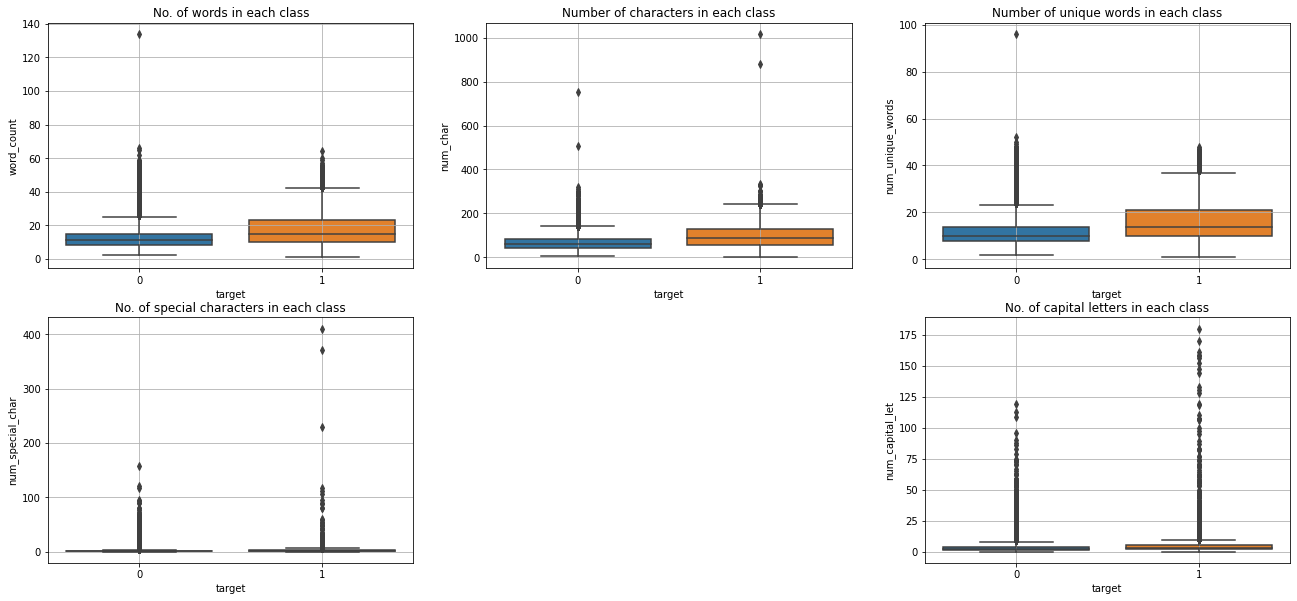

In [154]:
# Boxplot: Number of words
plt.subplot(2, 3, 1)
display_boxplot('target', 'word_count', train_df, 'No. of words in each class')

# Boxplot: Number of chars
plt.subplot(2, 3, 2)
display_boxplot('target', 'num_char', train_df, 'Number of characters in each class')

# Boxplot: Number of unique words
plt.subplot(2, 3, 3)
display_boxplot('target', 'num_unique_words', train_df, 'Number of unique words in each class')

# Boxplot: Number of special characters
plt.subplot(2, 3, 4)
display_boxplot('target', 'num_special_char', train_df, 'No. of special characters in each class')

# Boxplot: Number of capital letters
plt.subplot(2, 3, 6)
display_boxplot('target', 'num_capital_let', train_df, 'No. of capital letters in each class')


plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

Từ dữ liệu các đặc trưng trên, ta xuất ra **Correlation Matrix** để có thể rút ra thêm ý nghĩa:

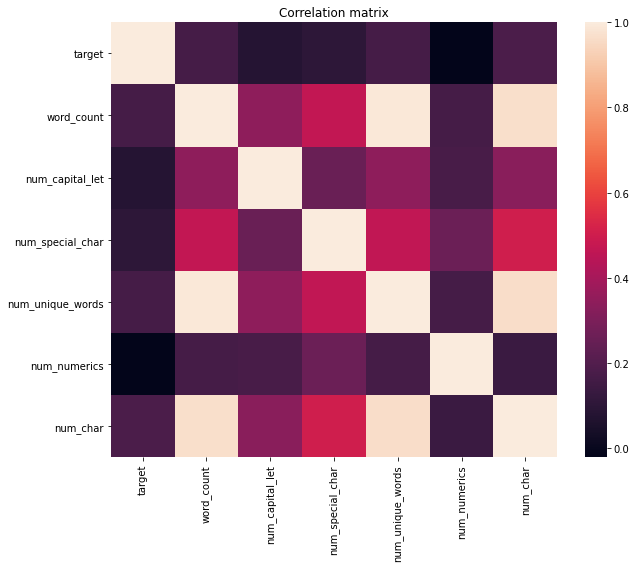

In [155]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = train_df.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

**Nhận xét**: 

Cùng với kết luận từ mục c, ta cũng thấy rằng câu hỏi thiếu chân thành xuất hiện nhiều chữ cái và ký tự hơn.

Các câu hỏi thiếu chân thành cũng có vẻ có nhiều từ độc nhất (unique word) hơn.

Có rất nhiều ký tự đặc biệt, cũng như các ký tự số và chữ viết hoa mà có thể thấy rằng đã làm loãng dữ liệu, không giúp ích trong việc phân loại.

**Giải pháp**: Tiền xử lý dữ liệu bằng các phương pháp làm sạch cơ bản.


# 3. Tiền xử lý dữ liệu

## 3.1. Thiết kế giải pháp làm sạch dữ liệu

**Vấn đề**: Như đã nói ở phần 2, có rất nhiều chữ, ký tự, từ đặc biệt mà gây loãng dữ liệu.

**Giải pháp**:

* Stemming: Chuyển đổi các từ viết rút gọn về nguyên thể bằng cách xoá contraction.
* Punctuation: Xoá các dấu câu
* Tokenization: Phá các câu thành các từ đơn lẻ (tokenize)

* Lemmatization: Không được sử dụng vì sẽ làm sai từ gốc ban đầu trong một số trường hợp. (*caring/car/care*)
* Stopword: Trong học máy thống kê, việc loại bỏ các stopword như *the* là cần thiết. Tuy nhiên trong trường hợp sử dụng hướng đi của em thì cần phải giữ lại nguyên vẹn tất cả các từ để có thể vector hoá tất cả, để tạo ra embedding matrix đúng nhất.

In [7]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


punctuation = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
    '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
    '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
    '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
    '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
    '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
    '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
    '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
    '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
    '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
    '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
    '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
    '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
    '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
    '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
    '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
    '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
    '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
    '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
    '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
    '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
    '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
    '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
    '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
    '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
    '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
    '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
    '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
    '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
    '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
    '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
    '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
    '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
    '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
    '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
    '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

In [8]:
def clean_text(txt, contraction_dict=contraction_dict, punctuation=punctuation, mispell_dict=mispell_dict):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    """""

    def _get_contraction(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    # replace contractions
    def remove_contraction(text, contraction_dict):
        contractions, contractions_re = _get_contraction(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)
    
    # remove punctuations
    def remove_punctuation(text):
        txt  = "".join([char for char in text if char not in punctuation])
        return re.sub("[^a-zA-Z0-9]+", ' ', txt)
    
    # remove stopword
    def remove_stopword(words):
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        return words

    # correct mispell 
    def correct_mispell(words):
        for i in range(0, len(words)):
            if mispell_dict.get(words[i]) is not None:
                words[i] = mispell_dict.get(words[i])
            elif mispell_dict.get(words[i].lower()) is not None:
                words[i] = mispell_dict.get(words[i].lower())
        return words    
    
    # to lower case
    def to_lower(words):
        return words.lower()

    txt = remove_contraction(txt, contraction_dict)
    txt = remove_punctuation(txt)
    # split into words
    words = word_tokenize(txt)
    # words = remove_stopword(words)
    
    words = correct_mispell(words)
    
    cleaned_text = ' '.join(words)
    
    # to lower case
    cleaned_text = to_lower(cleaned_text)
    return cleaned_text

## 3.2. Làm sạch dữ liệu

In [10]:
# Start preprocessing train dataset and test dataset
tqdm.pandas()
train_df['cleaned_question_text'] = train_df['question_text'].progress_apply(lambda txt: clean_text(txt))
test_df['cleaned_question_text']  = test_df['question_text'].progress_apply(lambda txt: clean_text(txt))

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

In [159]:
train_df.head()

,qid,question_text,target,word_count,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,cleaned_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,why does velocity affect time does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,can i convert montra helicon d to a mountain b...


Có thể nhận ra sau khi làm sạch dữ liệu có khả năng sẽ để lại các câu hỏi trống rỗng, hoặc vô nghĩa, gây tác động tiêu cực lên mô hình.

In [11]:
# plot and remove NaN value in train_set
nan_rows = train_df[train_df['cleaned_question_text'].isnull(inplace=True)]
nan_rows

,qid,question_text,target,cleaned_question_text
226715,2c54e967503a5f62b911,'মহাবিশ্ব প্রতিনিয়ত প্রসারিত হচ্ছে' বিষয়টি উপ...,0,NaN
231111,2d332fda4589c8d08526,한국 고등학교는 몇시간 수업하니까?,0,NaN
419699,524197a26dc8a61ae15b,محمد صلاح صاحب أفضل هدف في نصف نهائي الشامبيون...,1,NaN
420816,527aac2ce6f12f789fe5,"""",1,NaN
475230,5d109567741615222cdf,Какая компания сегодня создала самый мощный ис...,0,NaN
1264281,f7c403b45ab6dc4bc98e,आपकी कंपनी ने गरीब भारतीयों के लिए क्या चमत्का...,1,NaN


In [15]:
train_df = train_df[train_df['cleaned_question_text'].notna()]

In [16]:
# compression_opts = dict(method='zip', archive_name='out.csv')  
# train_df.to_csv("./train_processed.zip", index=False, compression=compression_opts)

train_df.to_csv('./train_preprocessed.csv', index=False)
test_df.to_csv('./test_preprocessed.csv', index=False)

In [168]:
train_df.head()

,qid,question_text,target,word_count,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,cleaned_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,why does velocity affect time does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,can i convert montra helicon d to a mountain b...


## 3.3. Load dataset

In [17]:
TEXT  = data.Field(tokenize='spacy', batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.int64, batch_first=True)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [18]:
fields = [(None, None), (None,None), ('target', LABEL), ('text', TEXT)]

# TabularDataset from torchtext only support to load from storage file
dataset = data.TabularDataset('./train_preprocessed.csv', format = 'csv', fields = fields, skip_header = True)

/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [19]:
# log data example
print(vars(dataset.examples[0]))

{'target': '0', 'text': ['how', 'did', 'quebec', 'nationalists', 'see', 'their', 'province', 'as', 'a', 'nation', 'in', 'the', '1960s']}


## 3.4. Chia tập dữ liệu Validation

Lấy tỉ lệ 8-2 để chia bộ dữ liệu ra 2 phần `training_set` và `valid_set`.

In [20]:
import random

SEED = 42
torch.manual_seed(SEED)
training_set, valid_set = dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

# 4. Trích xuất đặc trưng

Để bắt đầu, ta sẽ tìm hiểu về **GloVe** - Global Vectors for Word Representation:

Do số lượng đặc trưng (từ trong từ điển) là khá lớn (nhược điểm của one-hot vector, kỹ thuật biểu diễn từ bằng vector có số chiều bằng số từ vựng), nên Embedding được tạo ra để giảm số chiều của không gian đặc trưng. Cụ thể là mỗi từ sẽ được biểu diễn bằng một vector có số chiều xác định.

![alt text](https://miro.medium.com/max/2456/1*gcC7b_v7OKWutYN1NAHyMQ.png "Visualization của Embedding Matrix")

![alt text](https://miro.medium.com/max/2892/1*KdJGfpGf7eApnKuSZDv2ZQ.png)



Để load file embeddings sau này, ta thực hiện kéo về giải nén.

In [21]:
!unzip ../input/quora-insincere-questions-classification/embeddings.zip -d ./

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: ./GoogleNews-vectors-negative300/
   creating: ./glove.840B.300d/
   creating: ./paragram_300_sl999/
   creating: ./wiki-news-300d-1M/
  inflating: ./glove.840B.300d/glove.840B.300d.txt  
  inflating: ./GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: ./wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: ./paragram_300_sl999/README.txt  
  inflating: ./paragram_300_sl999/paragram_300_sl999.txt  


Xoá bỏ các file không cần thiết.

In [22]:
#due to the space limitation of kaggle, we must clear non use embedding.
NON_USE_DIR = ['./wiki-news-300d-1M/', './GoogleNews-vectors-negative300', './paragram_300_sl999']

import os, shutil
def remove_dir(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    os.rmdir(path)
            
for dir in NON_USE_DIR:
    remove_dir(dir)

Load file embedding **GloVe** đã giải nén.

In [ ]:
# Load embedding as storage file
import torchtext.vocab as vocab

custom_embeddings = vocab.Vectors(name = './glove.840B.300d/glove.840B.300d.txt')

Tham chiếu từ điển của bộ dữ liệu (training data) để tạo ma trận nhúng cho bộ từ điển.

Tokenization cũng được thực hiện ở đây.

In [24]:
TEXT.build_vocab(training_set, min_freq=3, vectors = custom_embeddings)
LABEL.build_vocab(training_set)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10)) 

Size of TEXT vocabulary: 64732
Size of LABEL vocabulary: 2
[('the', 531950), ('what', 377341), ('is', 365179), ('a', 327171), ('to', 325910), ('in', 301508), ('of', 266616), ('i', 264847), ('how', 232081), ('do', 218224)]


# 5. Khởi tạo mô hình huấn luyện

**Vấn đề**: Xét dữ liệu ta cần xử lý là dạng văn bản, hay nói cách khác, đó là dữ liệu mang tính liên tục, khác với dữ liệu rời rạc như các tấm ảnh.

**Giải pháp**: 

Trong việc lựa chọn mô hình huấn luyện thích hợp, em đã chọn sử dụng RNN - Recurrent Neural Network.

Mạng nơ ron hồi quy (RNN) là một loại Mạng nơ ron trong đó đầu ra từ các bước trước được cung cấp làm đầu vào cho bước hiện tại, do đó ghi nhớ một số thông tin về trình tự. 
Nó có những hạn chế như khó nhớ các chuỗi dài hơn.

Việc sử dụng RNN giúp xử lý vấn đề về dữ liệu liên tục, không giống với CNN dành cho dạng dữ liệu rời rạc.



## 5.1. Bidirectional LSTM Model


In [27]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

LSTM / GRU là phiên bản cải tiến của RNN, chuyên ghi nhớ thông tin trong một thời gian dài bằng cách sử dụng cơ chế kiểm soát mà RNN không thực hiện được. 

![](https://miro.medium.com/max/875/0*Q0uzj4QO5OQADSSX.png)

RNN đơn hướng chỉ lưu giữ thông tin của quá khứ vì các đầu vào mà nó đã thấy là từ quá khứ. Sử dụng LSTM hai chiều sẽ chạy các đầu vào theo hai cách, một từ quá khứ đến tương lai và một từ tương lai đến quá khứ cho phép nó lưu giữ thông tin theo ngữ cảnh từ cả quá khứ và tương lai vào bất kỳ thời điểm nào. 

In [28]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layer, output_size, dropout_rate=0.1):
        super(BidirectionalLSTM, self).__init__()
        self.dimension = hidden_size
        # Define layer
        self.embedding   = nn.Embedding(vocab_size, embedding_dim)
        self.lstm        = nn.LSTM(embedding_dim, hidden_size, num_layer, batch_first=True, bidirectional=True)
        self.dropout     = nn.Dropout(0.1)
        self.fc          = nn.Linear(hidden_size*2, output_size)
        self.sigmoid     = nn.Sigmoid()

    def forward(self, input, input_len):
        # embedding word
        x = self.embedding(input)
        
        x = pack_padded_sequence(x, input_len.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        out_forward = output[range(len(output)), input_len.cpu() - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_feature = self.dropout(out_reduced)

        text_feature = self.fc(text_feature).squeeze(1)
        return self.sigmoid(text_feature)
        
        
        # Notes!
#         output = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
#         output = self.fc(output)
#         return self.sigmoid(output)

## 5.2. Cải tiến

Sau khi có được kết quả từ LSTM đã sử dụng bên trên, em thực hiện nghiên cứu và thử nghiệm một cấu trúc mạng như ảnh dưới đây.

Đặc điểm của nó là **xếp chồng hai mạng nơ ron LSTM và GRU hai chiều** với nhau, kết hợp thêm lớp **Dropout**, **Max Pooling** để tăng khả năng biểu diễn ngôn ngữ.

![LSTM model](https://i.ibb.co/XLwSTTD/download-1.png)

* **LSTM**: Lọc bộ nhớ hiện tại, chắt lọc thông tin hiện tại để đưa vào bộ nhớ và kết hợp bộ nhớ và dữ liệu hiện tại để đưa ra đầu ra bằng 4 cổng.

* **GRU** - Gated Recurrent Unit: Khác với LSTM, GRU chỉ có 2 cổng để chắt lọc thông tin, cổng reset và cổng update. Nó không có trạng thái cell mà chỉ có đầu ra vừa dùng để đưa ra quyết định vừa dùng để thông tin cho các bước tiếp theo.

* **Dropout**: Bởi vì lượng dữ liệu đưa vào model bị lệch rất nhiều, nên ta cần sử dụng lớp Dropout.
Bỏ qua một vài unit trong suốt quá trình train trong mô hình, những unit bị bỏ qua được lựa chọn ngẫu nhiên, để tráng overfit.

* **Max Pooling**: Một layer nén thông tin để đơn giản hóa thông tin đầu ra để giảm bớt số lượng neuron.

In [29]:
class LSTM_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layer, output_size, dropout_rate=0.1):
        super(LSTM_GRU, self).__init__()
        # Define layer
        self.embedding   = nn.Embedding(vocab_size, embedding_dim)
        self.lstm        = nn.LSTM(embedding_dim, hidden_size, num_layer, batch_first=True, bidirectional=True)
        self.gru         = nn.GRU(hidden_size*2, hidden_size//2, num_layer, batch_first=True, bidirectional=True)

        self.fc          = nn.Linear(hidden_size*3, output_size)
        
        self.emb_dropout = nn.Dropout2d(dropout_rate)
        self.sigmoid     = nn.Sigmoid()

    def forward(self, input, input_len):
        # layer 1: embedding
        x = self.embedding(input)
        
        # layer 2: Spatial Dropout 1D
        embed = x.unsqueeze(2) # (N, T, 1, K)
        embed = embed.permute(0, 3, 2, 1)  # (N, K, 1, T)
        embed = self.emb_dropout(embed)  # (N, K, 1, T)
        embed = embed.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = embed.squeeze(2)  # (N, T, K)
        
        # layer 3: Bidirectional LSTM
        x = pack_padded_sequence(x, input_len.cpu(), batch_first=True, enforce_sorted=False) # (N, T, K)
        packed_lstm, h_lstm = self.lstm(x)
        
        # layer 4: Bidirectional GRU
        packed_gru, h_gru = self.gru(packed_lstm)
        
        packed_lstm = pad_packed_sequence(packed_lstm, batch_first=True)
        packed_gru = pad_packed_sequence(packed_gru, batch_first=True)
        
        # layer 5: Concat
        x = torch.cat((packed_gru[0], packed_lstm[0]), 2)
        
        # layer 6: Global Average Pool
        avg_pool = torch.mean(x, 1)
        
        # layer 7: Fully connected
        x = self.fc(avg_pool)
        x = self.sigmoid(x)
        return x

**F1 Score** được tính như bên dưới. Chi tiết đã được viết ở phần 1.4. Đánh giá.

In [30]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
#     f1.requires_grad = is_training
    return f1

Quá trình train:

* `load data`

* `forward`: Đẩy input vào model cũng như tính loss.

* `zero_grad`: Để grad trở về 0 trước khi chạy.

* `backpropagation`: Đạo hàm ngược để tiến hành backpropagation.

In [31]:
def train(model, device, train_iterator, optimizer, loss_function):
    model.train()
    running_loss = 0
    accuracy     = 0
    for input, target in train_iterator:
        input, input_len, target = input[0].to(device), input[1].to(device), target.to(device, dtype=torch.float32)

        # forward
        predict = model(input, input_len).squeeze()
        loss = loss_function(predict, target)

        # metric
        accuracy     += f1_loss(predict, target)
        running_loss += loss.item()
        
        # zero the gradient 
        optimizer.zero_grad()

        # backpropagation + step
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss/len(train_iterator)
    epoch_acc  = accuracy/len(train_iterator)

    return epoch_loss, epoch_acc

`no_grad`: giúp file test không bị mô hình nhớ

Sau đó mô hình sẽ chạy để tính loss và accuracy.

In [32]:
def test(model, device, test_iterator, loss_function):
    model.eval()
    running_loss = 0
    accuracy     = 0
    
    with torch.no_grad():
        for input, target in test_iterator:
            input, input_len, target = input[0].to(device), input[1].to(device), target.to(device, dtype=torch.float32)

            predict = model(input, input_len).squeeze()
            loss = loss_function(predict, target)

            running_loss += loss.item()
            accuracy     += f1_loss(predict, target)

    epoch_loss = running_loss/len(test_iterator)
    epoch_acc  = accuracy/len(test_iterator)
    
    return epoch_loss, epoch_acc

# 6. Huấn luyện

## 6.1. Cài đặt thiết lập

In [51]:
# using cuda
device = f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"
print("Training on:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu")

# config
BATCH_SIZE       = 64
VOCAB_SIZE       = len(TEXT.vocab)
EMBEDDING_DIM    = 300
HIDDEN_SIZE      = 128
OUTPUT_SIZE      = 1
NUM_LAYER        = 2

N_EPOCH          = 10

Training on: Tesla P100-PCIE-16GB


Load iterator để trỏ vào giá trị trong tập dữ liệu.

In [34]:
#Load an iterator
train_iterator = data.BucketIterator(training_set, batch_size = BATCH_SIZE, 
                                     sort_key = lambda x: len(x.text), sort=True, sort_within_batch=True, device=device)
valid_iterator = data.BucketIterator(valid_set, batch_size = BATCH_SIZE, 
                                     sort_key = lambda x: len(x.text), sort=True, sort_within_batch=True, device=device)


/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## 6.2. Khởi tạo model

Em sử dụng **Adam** từ thư viện torch làm **optimizer** với mục đích cập nhật trọng số.

**Loss function** sử dụng **Binary Cross entropy**, được thiết kế để thích nghi với những bài toán 2 class.





**Learning Rate** trong quá trình tuning đã cho thấy sẽ đạt kết quả tốt hơn nếu > 0.0003 và < 0.001. Vì vậy em lựa chọn lr=0.0004 cho version này.

In [52]:
# init model
model = LSTM_GRU(vocab_size=VOCAB_SIZE, 
             embedding_dim=EMBEDDING_DIM, 
             hidden_size=HIDDEN_SIZE, 
             num_layer=NUM_LAYER, 
             output_size=OUTPUT_SIZE).to(device)

# model.load_state_dict(torch.load('./weights.pt'))

# loss function & optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.07)

citeration = nn.BCELoss()

In [41]:
#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

torch.Size([64732, 300])


## 6.3. Tiến hành huấn luyện

In [42]:
# Start training
best_accuracy = 0

train_losses, train_res = [], []
valid_losses, valid_res = [], []

for epoch in range(N_EPOCH):
    # train
    train_loss, train_accuracy = train(model, device, train_iterator, optimizer, citeration)
    train_losses.append(train_loss)
    train_res.append(train_accuracy)
    
    # evaluate
    test_loss, test_accuracy = test(model, device, valid_iterator, citeration)
    valid_losses.append(test_loss)
    valid_res.append(test_accuracy)
    
    #save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), './weights.pt')
    
    print(f'Epoch {epoch+1} summary ===========================')
    print(f'Train Loss: {train_loss:.3f} | Train F1 score: {train_accuracy*100:.2f}%')
    print(f' Val. Loss: {test_loss:.3f} |  Val. F1 score: {test_accuracy*100:.2f}%')

Epoch 1 summary ===========================
Train Loss: 0.110 | Train F1 score: 41.13%
 Val. Loss: 0.270 |  Val. F1 score: 32.49%
Epoch 2 summary ===========================
Train Loss: 0.096 | Train F1 score: 47.40%
 Val. Loss: 0.264 |  Val. F1 score: 32.78%
Epoch 3 summary ===========================
Train Loss: 0.087 | Train F1 score: 51.35%
 Val. Loss: 0.251 |  Val. F1 score: 33.61%
Epoch 4 summary ===========================
Train Loss: 0.079 | Train F1 score: 55.07%
 Val. Loss: 0.264 |  Val. F1 score: 34.20%
Epoch 5 summary ===========================
Train Loss: 0.072 | Train F1 score: 58.15%
 Val. Loss: 0.312 |  Val. F1 score: 32.11%
Epoch 6 summary ===========================
Train Loss: 0.067 | Train F1 score: 60.57%
 Val. Loss: 0.334 |  Val. F1 score: 32.36%
Epoch 7 summary ===========================
Train Loss: 0.064 | Train F1 score: 62.33%
 Val. Loss: 0.394 |  Val. F1 score: 30.63%


KeyboardInterrupt: 

*Visualize training experiment*

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

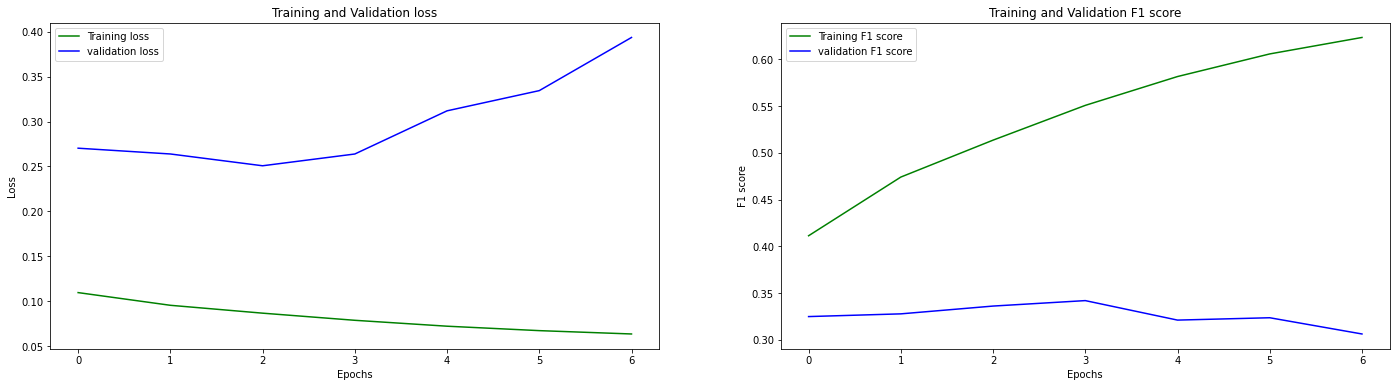

In [44]:
epoch = range(0, len(train_losses))

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(24, 6))

ax0.plot(epoch, train_losses, 'g', label='Training loss')
ax0.plot(epoch, valid_losses, 'b', label='validation loss')
ax0.set_title('Training and Validation loss')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(epoch, train_res, 'g', label='Training F1 score')
ax1.plot(epoch, valid_res, 'b', label='validation F1 score')
ax1.set_title('Training and Validation F1 score')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('F1 score')
ax1.legend()

plt.show()

In [45]:
# plot confusion matrix
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))

with torch.no_grad():
    for input, target in test_iterator:
        input, input_len, target = input[0].to(device), input[1].to(device), target.to(device, dtype=torch.float32)

        predict = model(input, input_len).squeeze()
        loss = loss_function(predict, target)

        
#         _, preds = torch.max(outputs, 1)
        for t, p in zip(target.view(-1), predict.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

NameError: name 'test_iterator' is not defined

**Khó khăn và bài học rút ra**: Có thể thấy mô hình đang bị **underfit**. Nguyên nhân có thể là:

* Mô hình chưa đủ khả năng biểu diễn

* Quá trình cài đặt loss function có thể chưa chính xác

**Giải pháp**: 

* Tăng số lượng parameter

* Tăng cường data (Data Augmentation)

# 7. Dự đoán kết quả

In [46]:
# test dataset
test_df = pd.read_csv('./test_preprocessed.csv')
test_df.head()

,qid,question_text,cleaned_question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,when should i apply for rv college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...,what is it really like to be a nurse practitioner
3,000086e4b7e1c7146103,Who are entrepreneurs?,who are entrepreneurs
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,is education really making good people nowadays


## 7.1. Helper Function

In [47]:
# helper function
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence # nlp.tokenizer(sentence)
    indexed   = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    
    try:
        prediction = model(tensor, length_tensor)              #prediction 
    except:
        # print("Empty sentence:", sentence)
        return 0
    
    return prediction.item()   

## 7.2. Trả kết quả

In [48]:
raw_prediction, prediction = [], []
THRES_HOLD = 0.32

model.load_state_dict(torch.load('./weights.pt'))
model.eval()

for idx, row in test_df.iterrows():
    pred = 0
    raw_pred = predict(model, row['cleaned_question_text'])
    if raw_pred >= THRES_HOLD:
        pred = 1
        
    # save to list
    prediction.append(pred)
    raw_prediction.append(raw_pred)

print('# of prediction', len(prediction))

# of prediction 375806


In [49]:
# merge
test_df['raw_prediction'] = raw_prediction
test_df['prediction'] = prediction

test_df.head(10)

,qid,question_text,cleaned_question_text,raw_prediction,prediction
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,why do so many women become so rude and arroga...,0.953688,1
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,when should i apply for rv college of engineer...,0.000242,0
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...,what is it really like to be a nurse practitioner,0.002078,0
3,000086e4b7e1c7146103,Who are entrepreneurs?,who are entrepreneurs,0.065170,0
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,is education really making good people nowadays,0.242668,0
5,000101884c19f3515c1a,How do you train a pigeon to send messages?,how do you train a pigeon to send messages,0.170501,0
6,00010f62537781f44a47,What is the currency in Langkawi?,what is the currency in langkawi,0.029410,0
7,00012afbd27452239059,"What is the future for Pandora, can the busine...",what is the future for pandora can the busines...,0.009272,0
8,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,my voice range is a2c5 my chest voice goes up ...,0.001329,0
9,000156468431f09b3cae,How much does a tutor earn in Bangalore?,how much does a tutor earn in bangalore,0.003097,0


Nộp bài:

In [50]:
prediction_df = test_df.drop(['question_text', 'cleaned_question_text', 'raw_prediction'], axis=1)
prediction_df.to_csv('./submission.csv', index=False)

prediction_df.head(10)

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
5,000101884c19f3515c1a,0
6,00010f62537781f44a47,0
7,00012afbd27452239059,0
8,00014894849d00ba98a9,0
9,000156468431f09b3cae,0
